# Evaluation of the sea ice thickness in the CMIP6 historical experiments

## User question
How well does the sea ice thickness in the CMIP6 historical experiments compare to sea ice thickness estimates from altimetry?

## 📋 Methodology
For each model in the CMIP6 historical experiment that outputs sea ice thickness, we calculate time series of bias and RMSE for the models compared to sea ice thickness estimates from altimetry - from the ENVISAT product between 2002 and April 2010, and from the CryoSat-2 product after October 2010. We then make plots of the time series showing the median and interquartile limits of the CMIP6 ensemble.

We also calculate monthly thickness climatologies for the ENVISAT period and the CryoSat-2 period, and plot them to compare the spatial distribution of the thickness fields and the biases.

Finally we calculate the difference between the climatologies for the CryoSat-2 and ENVISAT periods, to compare the change in thickness over time for the model and the satellites.

## Summary
On average the sea ice thickness from the CMIP6 ensemble is fairly unbiased against the altimeter-based estimates, with the exception of October. However the bias starts to become negative towards the end of the historical experiment in 2013 and 2014. The RMSE is consistently about 1m though, indicating some compensating bias. This is confirmed by the spatial maps of climatologies of the bias, which show that in the ENVISAT period the Beaufort Sea has a strong positive bias, while the Laptev, Kara and Barents Seas have more of a negative bias. In the CryoSat-2 period, the spatial distribution of the bias changes with the Beafort, Laptev, Kara and Barents Seas all having a positive bias, while the Greenland Sea, and the area extending from the north of Greenland to the north pole have a strong negative bias, making the mean bias negative.
Spatially, the CMIP6 model mean has a fairly uniform drop in thickness when we compare the difference between its post-2010 climatology and its 2002-2010 one, while the difference in the altimeter climatologies is more variable spatially.

## Code

### Import libraries

In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
from c3s_eqc_automatic_quality_control import diagnostics, download, plot
import calendar
import cartopy.crs as ccrs
from cmocean import cm

plt.style.use("seaborn-v0_8-notebook")
warnings.filterwarnings("ignore", module="cf_xarray")

### Set parameters

In [2]:
year_start = 2002
year_stop = 2014
assert year_start >= 2002 and year_stop <= 2014

# Choose CMIP6 historical models
models = [
    "access_cm2",
    "access_esm1_5",
    "canesm5",
    "cmcc_cm2_sr5",
    "cmcc_esm2",
    "cnrm_cm6_1",
    "cnrm_cm6_1_hr",
    "cnrm_esm2_1",
    "e3sm_1_0",
    "e3sm_1_1",
    "e3sm_1_1_eca",
    "ec_earth3_aerchem",
    "ec_earth3_cc",
    "ec_earth3_veg_lr",
    "hadgem3_gc31_ll",
    "ipsl_cm5a2_inca",
    "ipsl_cm6a_lr",
    "miroc6",
    "miroc_es2l",
    "mpi_esm1_2_hr",
    "mpi_esm1_2_lr",
    "nesm3",
    "norcpm1",
    # "taiesm1", # very high values
    "ukesm1_0_ll",
]

### Define request

In [3]:
months = [f"{month:02d}" for month in [1, 2, 3, 4, 10, 11, 12]]
years = [str(year) for year in range(year_start, year_stop + 1)]

collection_id_cmip6 = "projections-cmip6"
request_cmip6 = {
    "format": "zip",
    "temporal_resolution": "monthly",
    "experiment": "historical",
    "variable": "sea_ice_thickness",
    "month": months,
}

year_ranges = {
    "envisat": range(max(2002, year_start), min(2010, year_stop) + 1),
    "cryosat_2": range(max(2010, year_start), min(2020, year_stop) + 1),
}
collection_id_satellite = "satellite-sea-ice-thickness"
request_satellite = {
    "version": "2_0",
    "cdr_type": "cdr",
    "variable": "all",
    "month": months,
}

chunks = {"year": 1}

projection_satellite = ccrs.Stereographic(central_latitude=90)

### Functions to cache

In [4]:
def get_satellite_data(time):
    year_start = time.dt.year.min().values
    year_stop = time.dt.year.max().values

    year_ranges = {
        "envisat": range(max(2002, year_start), min(2010, year_stop) + 1),
        "cryosat_2": range(max(2010, year_start), min(2020, year_stop) + 1),
    }

    datasets = []
    for satellite, year_range in year_ranges.items():
        if not year_range:
            continue
        ds = download.download_and_transform(
            "satellite-sea-ice-thickness",
            {
                "satellite": satellite,
                "version": "2_0",
                "cdr_type": "cdr",
                "variable": "all",
                "year": list(map(str, year_range)),
                "month": [f"{month:02d}" for month in [1, 2, 3, 4, 10, 11, 12]],
            },
            chunks={"year": 1},
        )
        datasets.append(ds)
    return xr.concat(datasets, "time")


def regrid(obj, grid_out, **regrid_kwargs):
    # Remove nan columns
    for dim in [dim for dim in obj.dims if "x" in dim or "lon" in dim]:
        for i in (0, -1):
            if obj.isel({dim: i}).isnull().all():
                obj = obj.drop_isel({dim: i})
    return diagnostics.regrid(obj, grid_out, **regrid_kwargs)


def compare_model_vs_satellite(ds, ds_satellite):
    # Homogenize time
    ds = ds.convert_calendar("standard", align_on="date")
    ds["time"] = pd.to_datetime(ds["time"].dt.strftime("%Y-%m"))
    ds_satellite = ds_satellite.convert_calendar("standard", align_on="date")

    # Get variables
    dims = ("xc", "yc")
    std_name = "sea_ice_thickness"
    sit = ds.cf[std_name]
    sit_obs = ds_satellite.cf[std_name]
    sit_obs_err = ds_satellite.cf[f"{std_name} standard_error"]
    sit_model = sit.sel(time=sit_obs["time"])

    # Compute useful variables
    sit_diff = sit_model - sit_obs

    # Compute output
    dataarrays = {}
    dataarrays["sithick_bias"] = sit_diff.mean(dim=dims)
    dataarrays["sithick_bias"].attrs = {
        "standard_name": "sea_ice_thickness_bias",
        "units": "m",
        "long_name": "Sea ice thickness bias",
    }

    dataarrays["sithick_rmse"] = (sit_diff ** 2).mean(dim=dims) ** (1 / 2)
    dataarrays["sithick_rmse"].attrs = {
        "standard_name": "sea_ice_thickness_rmse",
        "units": "m",
        "long_name": "Sea ice thickness root mean square error",
    }

    dataarrays["rms_sit_obs_error"] = (sit_obs_err ** 2).mean(dim=dims) ** (1 / 2)
    dataarrays["rms_sit_obs_error"].attrs = {
        "standard_name": "root_mean_square_sea_ice_thickness_observation_error",
        "units": "m",
        "long_name": "Root mean square sea ice thickness observation error",
    }

    return xr.Dataset(dataarrays)


def compute_sea_ice_thickness_diagnostics(ds, **regrid_kwargs):
    ds_satellite = get_satellite_data(ds["time"])
    ds = regrid(ds, ds_satellite[["latitude", "longitude"]], **regrid_kwargs)
    return compare_model_vs_satellite(ds, ds_satellite)


def regridded_monthly_weighted_mean(ds, times, **kwargs):
    ds_sat = download.download_and_transform(
        "satellite-sea-ice-thickness",
        {
            "satellite": "envisat",
            "version": "2_0",
            "cdr_type": "cdr",
            "variable": "all",
            "year": "2002",
            "month": [f"{month:02d}" for month in [1, 2, 3, 4, 10, 11, 12]],
        },
        chunks={"year": 1},
    )
    ds["time"] = pd.to_datetime(ds["time"].dt.strftime("%Y-%m"))
    ds["time"].attrs["standard_name"] = "time"
    ds = ds.sel(time=times)
    ds = diagnostics.monthly_weighted_mean(ds)
    return diagnostics.regrid(ds, ds_sat[["latitude", "longitude"]], **kwargs)

### Function to plot error time series

In [5]:
def plot_error_time_series(ds_cmip6):
    err_name = "rms_sit_obs_error"
    rms_error = (ds_cmip6[err_name]
                 .mean(dim="model") # independent of model
                 .resample(time="1MS").mean() # fills summer months with NaN
                )
    ds_quantiles = (ds_cmip6
                    .drop_vars([err_name])
                    .resample(time="1MS").mean() # fills summer months with NaN
                    .quantile([1 / 4, 1 / 2, 3 / 4], dim="model", keep_attrs=True)
                   )
    fig, axs = plt.subplots(len(ds_quantiles.data_vars), 1, sharex=True)
    
    for (var, da), ax in zip(ds_quantiles.data_vars.items(), axs.flatten()):
        # da = da.resample(time="1MS").mean()
        da.sel(quantile=1 / 2).drop_vars("quantile").plot(ax=ax, label="median")
        ax.fill_between(
            da["time"],
            da.sel(quantile=1 / 4),
            da.sel(quantile=3 / 4),
            alpha=0.5,
            label="IQL",
        )
        ylim = list(ax.get_ylim())
        if "bias" in var:
            ax.fill_between(
                rms_error["time"],
                - rms_error,
                rms_error,
                alpha=0.25,
                label="Obs. error",
                color='gray'
            )
        else:
            ax.fill_between(
                rms_error["time"],
                rms_error,
                np.sqrt(2) * rms_error, # test if model error is <= obs error
                alpha=0.25,
                label="Obs. error",
                color='gray'
            )
            ylim[0] -= .15
            ax.set_ylim(ylim)
        ax.plot(2 * [pd.Timestamp(2010,7,1)], ylim, '--r')
        ax.legend()
        ax.grid()

### Functions to plot maps

In [6]:
def postprocess_map_datasets(ds_satellite, ds_cmip6):
    keep = ["longitude", "latitude", "sithick"]
    da_satellite = ds_satellite.rename_vars({"sea_ice_thickness": "sithick"})["sithick"]
    da_cmip6 = xr.where(ds_cmip6["sithick"] > 0, ds_cmip6["sithick"], np.nan)
    da = xr.concat([da_satellite, da_cmip6], "product")

    # reorder months
    month_inds = [4,5,6,0,1,2,3]
    da["month"] = [calendar.month_abbr[month] for month in da["month"].values[month_inds]]
    da.values = da.values[:,:,month_inds,:,:]

    # zoom in
    ix0 = 69
    sx = slice(ix0, ix0 + 294)
    iy0 = 60
    sy = slice(ix0, ix0 + 312)
    da = da[:,:,:,sy,sx]

    return da


def plot_sithick_maps(da, projection, satellite):
    sit = da.sel(satellite=satellite)
    sit["product"] = [{"envisat": "ENVISAT", "cryosat_2": "CryoSat-2"}[satellite], "CMIP6"]
    plot.projected_map(
        sit, col="product", row="month", projection=projection,
        robust=True, #vmin=-1, vmax=1, cmap=cm.balance,
    )


def plot_bias_maps(da, projection):
    bias = da.sel(product="cmip6") - da.sel(product="satellite")
    bias.attrs = {
        "long_name": f"Bias in s{da.attrs['long_name'][1:]}",
        "standard_name": f"bias_in_{da.attrs['standard_name']}",
        "units": da.attrs["units"],
    }
    plot.projected_map(
        bias, row="month", projection=projection,
        robust=True, vmin=-1, vmax=1, cmap=cm.balance,
    )


def plot_change_maps(da, projection):
    change = da.sel(satellite="cryosat_2") - da.sel(satellite="envisat")
    change.attrs = {
        "long_name": f"Change in s{da.attrs['long_name'][1:]}",
        "standard_name": f"change_in_{da.attrs['standard_name']}",
        "units": da.attrs["units"],
    }
    change["product"] = ["Satellite", "CMIP6"]
    plot.projected_map(
        change, col="product", row="month", projection=projection,
        robust=True, vmin=-.5, vmax=.5, cmap=cm.balance,
    )

### Download and transform

In [7]:
datasets = []
for model in models:
    print(f"{model=}")
    ds = download.download_and_transform(
        collection_id_cmip6,
        request_cmip6 | {"model": model, "year":  years},
        chunks=chunks,
        transform_func=compute_sea_ice_thickness_diagnostics,
        transform_func_kwargs={
            "method": "nearest_s2d",
            "periodic": True,
            "ignore_degenerate": True,
        },
    )
    datasets.append(ds.expand_dims(model=["model"]).compute())
ds_cmip6 = xr.concat(datasets, "model")

model='access_cm2'


100%|██████████| 13/13 [00:01<00:00, 11.88it/s]


model='access_esm1_5'


100%|██████████| 13/13 [00:00<00:00, 15.97it/s]


model='canesm5'


100%|██████████| 13/13 [00:00<00:00, 22.10it/s]


model='cmcc_cm2_sr5'


100%|██████████| 13/13 [00:00<00:00, 18.93it/s]


model='cmcc_esm2'


100%|██████████| 13/13 [00:00<00:00, 20.40it/s]


model='cnrm_cm6_1'


100%|██████████| 13/13 [00:00<00:00, 18.81it/s]


model='cnrm_cm6_1_hr'


100%|██████████| 13/13 [00:00<00:00, 17.39it/s]


model='cnrm_esm2_1'


100%|██████████| 13/13 [00:00<00:00, 15.02it/s]


model='e3sm_1_0'


100%|██████████| 13/13 [00:00<00:00, 20.42it/s]


model='e3sm_1_1'


100%|██████████| 13/13 [00:00<00:00, 19.97it/s]


model='e3sm_1_1_eca'


100%|██████████| 13/13 [00:00<00:00, 18.62it/s]


model='ec_earth3_aerchem'


100%|██████████| 13/13 [00:00<00:00, 19.73it/s]


model='ec_earth3_cc'


100%|██████████| 13/13 [00:00<00:00, 19.10it/s]


model='ec_earth3_veg_lr'


100%|██████████| 13/13 [00:01<00:00, 12.17it/s]


model='hadgem3_gc31_ll'


100%|██████████| 13/13 [00:00<00:00, 16.63it/s]


model='ipsl_cm5a2_inca'


100%|██████████| 13/13 [00:00<00:00, 17.77it/s]


model='ipsl_cm6a_lr'


100%|██████████| 13/13 [00:00<00:00, 21.93it/s]


model='miroc6'


100%|██████████| 13/13 [00:00<00:00, 22.75it/s]


model='miroc_es2l'


100%|██████████| 13/13 [00:00<00:00, 16.84it/s]


model='mpi_esm1_2_hr'


100%|██████████| 13/13 [00:00<00:00, 20.06it/s]


model='mpi_esm1_2_lr'


100%|██████████| 13/13 [00:00<00:00, 18.46it/s]


model='nesm3'


100%|██████████| 13/13 [00:00<00:00, 16.09it/s]


model='norcpm1'


100%|██████████| 13/13 [00:00<00:00, 23.72it/s]


model='ukesm1_0_ll'


100%|██████████| 13/13 [00:00<00:00, 18.78it/s]


In [8]:
datasets_satellite = []
datasets_cmip6 = []
for satellite, year_range in year_ranges.items():
    print(f"{satellite=}")
    years = list(map(str, year_range))
    ds = download.download_and_transform(
        collection_id_satellite,
        request_satellite | {"satellite": satellite, "year": years},
        chunks=chunks,
    )
    times = ds["time"].dt.strftime("%Y-%m").values.tolist()
    ds = diagnostics.monthly_weighted_mean(ds)
    datasets_satellite.append(
        ds.expand_dims(satellite=[satellite], product=["satellite"])
    )

    model_datasets = []
    for model in models:
        print(f"{model=}")
        ds = download.download_and_transform(
            collection_id_cmip6,
            request_cmip6 | {"model": model, "year": years},
            chunks=chunks,
            transform_chunks=False,
            transform_func=regridded_monthly_weighted_mean,
            transform_func_kwargs={
                "times": times,
                "method": "nearest_s2d",
                "periodic": True,
                "ignore_degenerate": True,
            },
        )
        model_datasets.append(
            ds.expand_dims(model=[model], satellite=[satellite], product=["cmip6"])
        )
    datasets_cmip6.append(
        xr.concat(model_datasets, "model").mean("model", keep_attrs=True)
    )

da_maps = postprocess_map_datasets(
    xr.concat(datasets_satellite, "satellite"),
    xr.concat(datasets_cmip6, "satellite"),
)
del(datasets_satellite, datasets_cmip6)

satellite='envisat'


100%|██████████| 9/9 [00:02<00:00,  3.09it/s]


model='access_cm2'
model='access_esm1_5'
model='canesm5'
model='cmcc_cm2_sr5'
model='cmcc_esm2'
model='cnrm_cm6_1'
model='cnrm_cm6_1_hr'
model='cnrm_esm2_1'
model='e3sm_1_0'
model='e3sm_1_1'
model='e3sm_1_1_eca'
model='ec_earth3_aerchem'
model='ec_earth3_cc'
model='ec_earth3_veg_lr'
model='hadgem3_gc31_ll'
model='ipsl_cm5a2_inca'
model='ipsl_cm6a_lr'
model='miroc6'
model='miroc_es2l'
model='mpi_esm1_2_hr'
model='mpi_esm1_2_lr'
model='nesm3'
model='norcpm1'
model='ukesm1_0_ll'
satellite='cryosat_2'


100%|██████████| 5/5 [00:01<00:00,  4.45it/s]


model='access_cm2'
model='access_esm1_5'
model='canesm5'
model='cmcc_cm2_sr5'
model='cmcc_esm2'
model='cnrm_cm6_1'
model='cnrm_cm6_1_hr'
model='cnrm_esm2_1'
model='e3sm_1_0'
model='e3sm_1_1'
model='e3sm_1_1_eca'
model='ec_earth3_aerchem'
model='ec_earth3_cc'
model='ec_earth3_veg_lr'
model='hadgem3_gc31_ll'
model='ipsl_cm5a2_inca'
model='ipsl_cm6a_lr'
model='miroc6'
model='miroc_es2l'
model='mpi_esm1_2_hr'
model='mpi_esm1_2_lr'
model='nesm3'
model='norcpm1'
model='ukesm1_0_ll'


## Results

### Time series of error metrics

Below we plot time series of the bias and RMSE in the sea ice thickness of the CMIP6 models compared to the altimetry data. The vertical red lines (mid-2010) divide the ENVISAT period (2002-2010) from the CryoSat-2 one (2010-2020 for the CDR, but the historical CMIP6 experiments finish in 2014). The bias in the models are generally about the same level as the observation error level ($\pm\sigma_{\rm obs}$, where $\sigma_{\rm obs}$ is the RMS error in the observations), and the ensemble median is close to zero for most of the time interval considered. Around 2014, however, the bias drops to about -0.25m compared to CryoSat-2.

Within each winter the bias is generally highest in October -  about 0.3m - 0.5m for ENVISAT and also in the 2011 winter. The intra-winter variability in the bias seems to reduce after this however.

It is worth remembering that ENVISAT has its own bias which has been estimated to be about -0.6m so the models are probably also underestimating the thickness by that amount in the ENVISAT period [1]. The bias in CryoSat-2 has been estimated to be about -0.11m [1] so it is a little surprising that the model bias does not become negative immediately upon the change in satellite but instead stays around zero from 2010 to 2013. However, the validation data which was used to estimate the bias was limited in space to 3 or 4 drilling sites in the Beafort Sea and some airborne electromagnetic tracks in the Beafort Sea and north of Greenland [1], so the satellite biases may not apply to the whole Arctic.

The RMSE is also relatively constant over the entire period and can be about 50% above the plotted error range which is taken to be $(\sigma_{\rm obs}, \sqrt{2}\sigma_{\rm obs})$ since the RMSE can never drop below $\sigma_{\rm obs}$. However in some years the median is near the error range and there is decent overlap between the IQL from the models and the error range. There is not such a clear intra-winter variability in this statistic as in the bias.

/data/common/miniforge3/envs/wp4/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


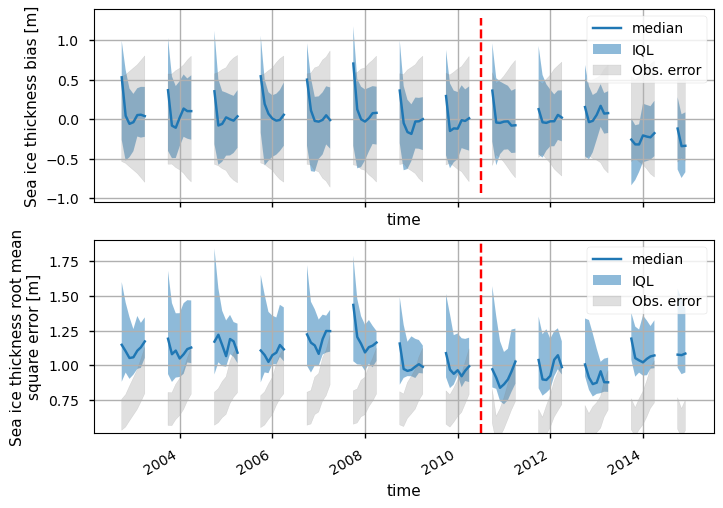

In [9]:
plot_error_time_series(ds_cmip6)

### Spatial distribution of errors

Below we plot monthly climatologies calculated from 2002 to 2010, of the thicknesses from ENVISAT and CMIP6 (the ensemble mean over all models), and the bias (model - observations) in the CMIP6 mean. The ice in the Canadian Archipelago is consistently very thick in the models for all months. In October there is a strong positive bias in the Beaufort sea, which, while present in all other months, is slightly reduced. This bias also extends spatially into the Siberian Sea for all months, although it is not as strong there. In the Eastern Arctic (the Laptev, Kara and Barents Seas), the Labrador Sea and Hudson Bay there are consistent negative biases. In the Greenland Sea the thickness is mostly negatively biased but in October there is a reasonably sized region of positive bias as well. In other months there is some positive bias there as well but the regions are smaller. Bear in mind, however, that considering such a dynamic region on a monthly time-scale may limit the conclusions that can be made about the Greenland Sea.

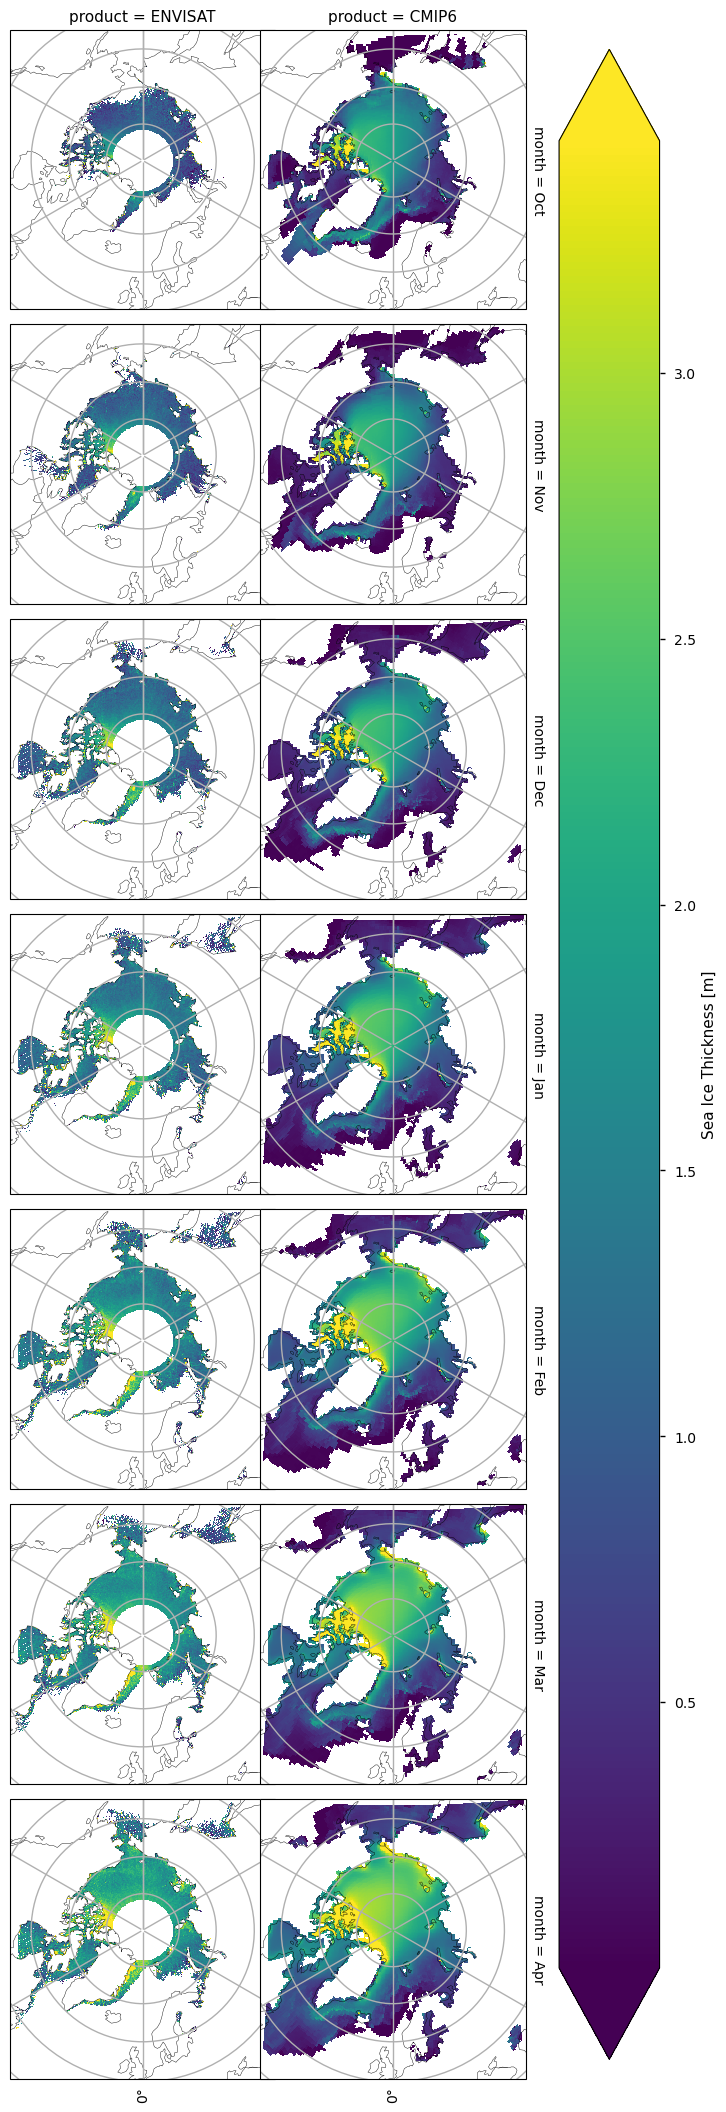

In [10]:
plot_sithick_maps(da_maps, projection_satellite, "envisat")

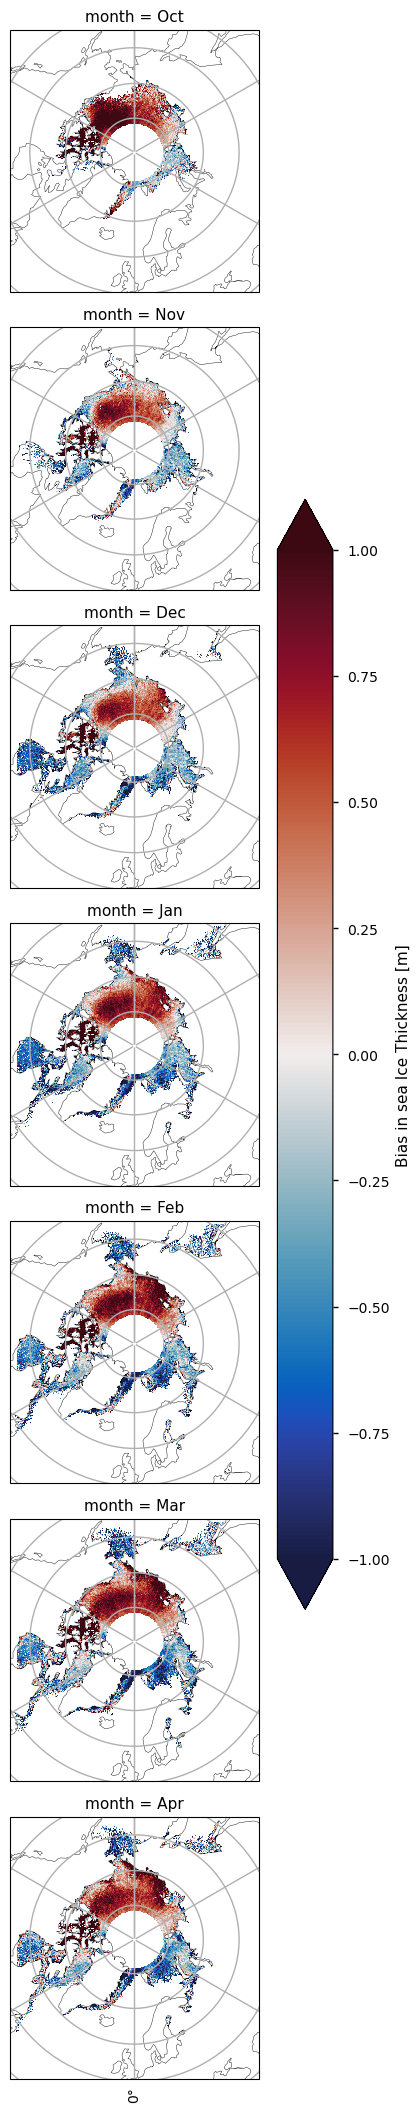

In [11]:
plot_bias_maps(da_maps.sel(satellite="envisat").squeeze(), projection_satellite)

Below we plot monthly climatologies calculated from 2010 to 2020, of the thicknesses from CryoSat-2 and CMIP6 (the ensemble mean over all models), and the bias (model - observations) in the CMIP6 mean. The ice in the Canadian Archipelago is still very thick in the models for all months. In October, there is a region of positive bias in the Beaufort, Siberian and Laptev seas. The extent of this region decreases as the months progress. There is a region of negative bias to the north of Greenland and the Canadian Archipelago, since the thicker ice off these coasts extends to the north pole in CryoSat-2 but is quite localised at the coasts in the models.

The ice in the Hudson Bay has a moderate negative bias, while the bias in the northern part of the Labrador Sea grows from around zero in November to about 25-50cm in April. Further south in the Labrador Sea there is a slight negative bias.

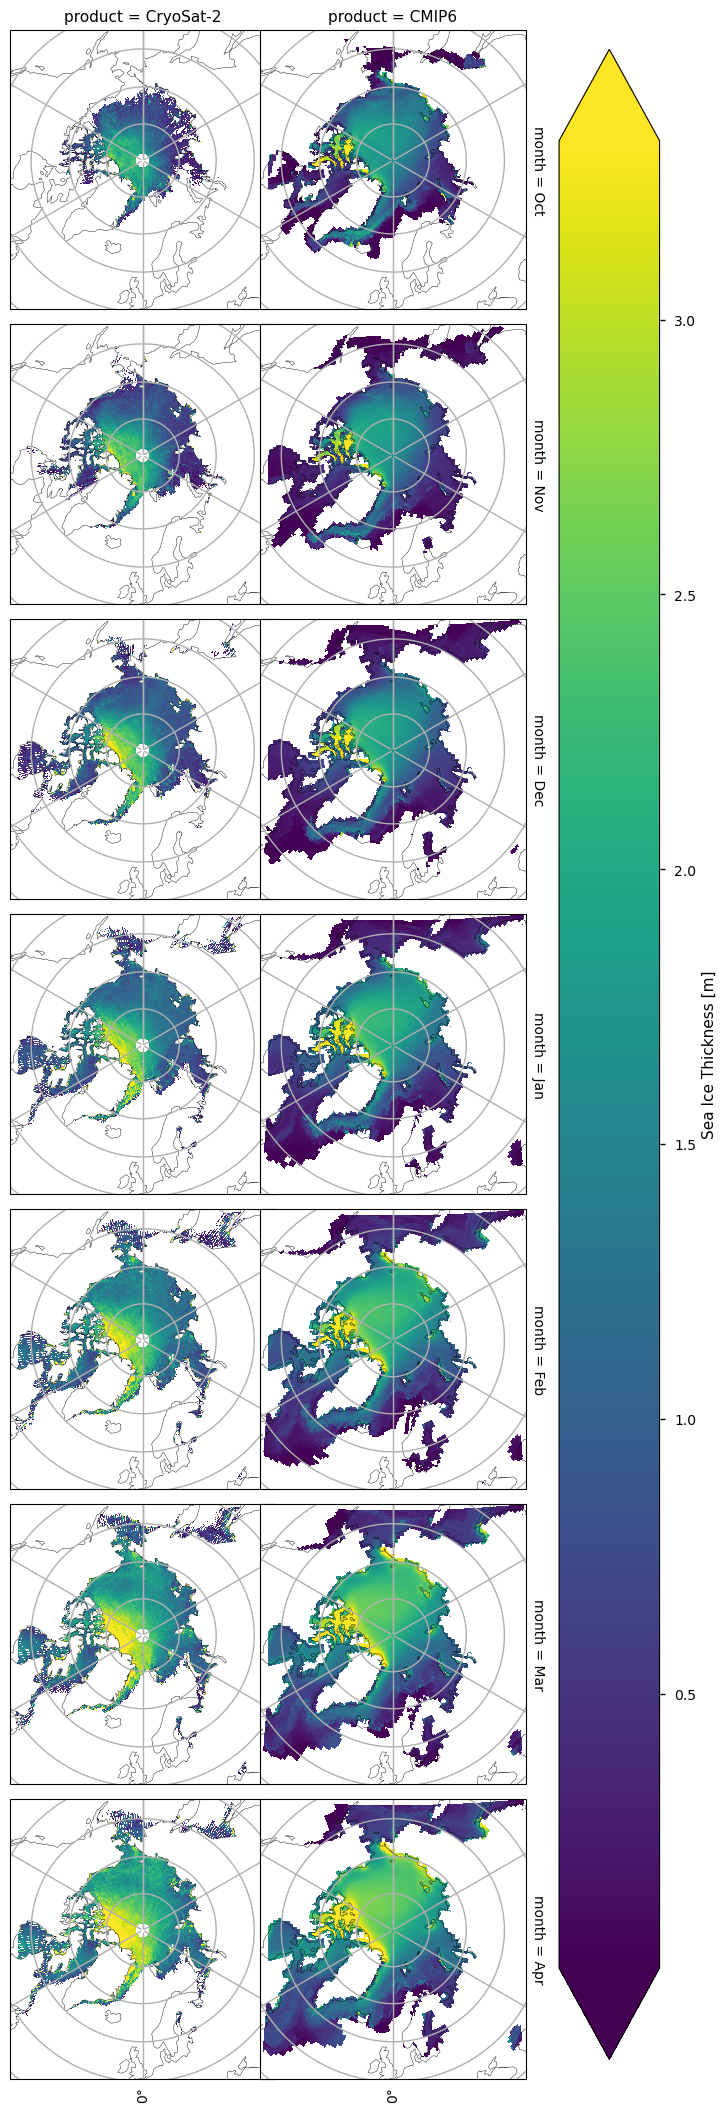

In [12]:
plot_sithick_maps(da_maps, projection_satellite, "cryosat_2")

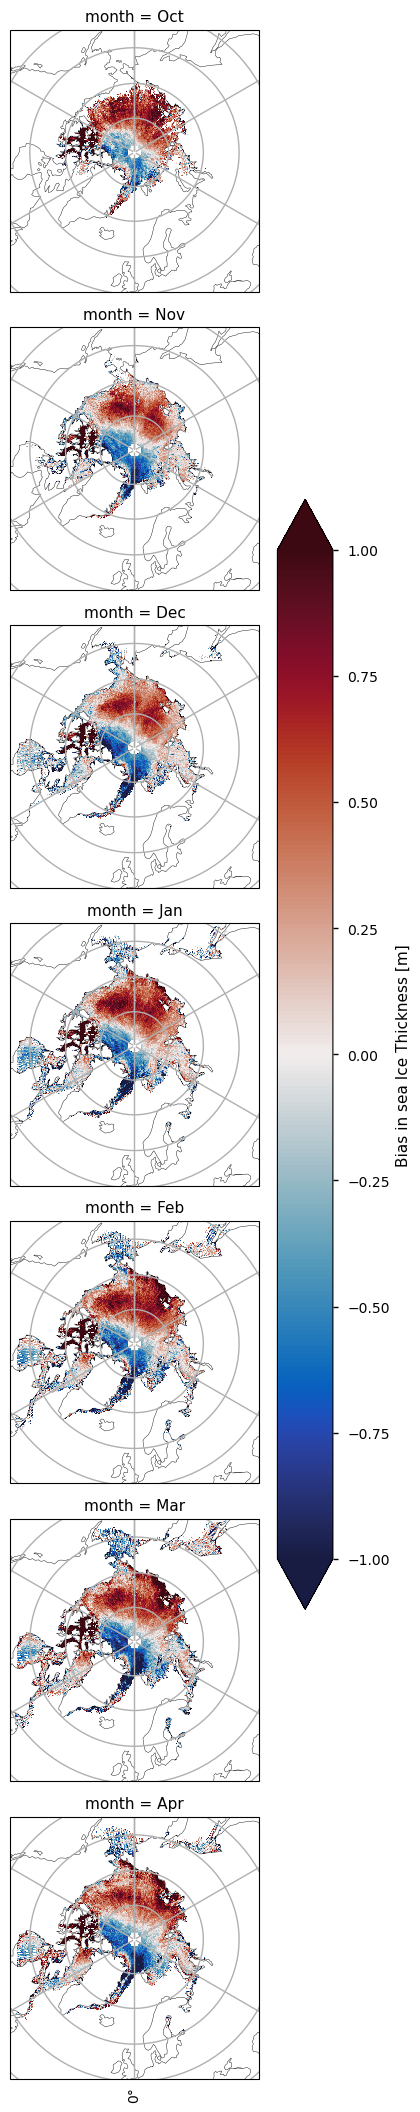

In [13]:
plot_bias_maps(da_maps.sel(satellite="cryosat_2").squeeze(), projection_satellite)

### Change in thickness over time

Below we compare the differences (later - earlier) in the two climatologies for the ENVISAT period and the CryoSat-2 one. The satellite products show a general decrease, with the exception of the Beaufort Sea in October, while the CMIP6 models show a near-uniform drop between the two periods. The magnitude of the drop is higher for the satellites however.
If we follow the estimated biases for each satellite, the change in the satellite thickness should drop by about 40cm, since ENVISAT has a larger negative bias than CryoSat-2. Hence we can theoretically trust decreases in the satellite thickness more than increases. However, as mentioned earlier, the validation data which was used to estimate the satellite biases was quite limited spatially [1].

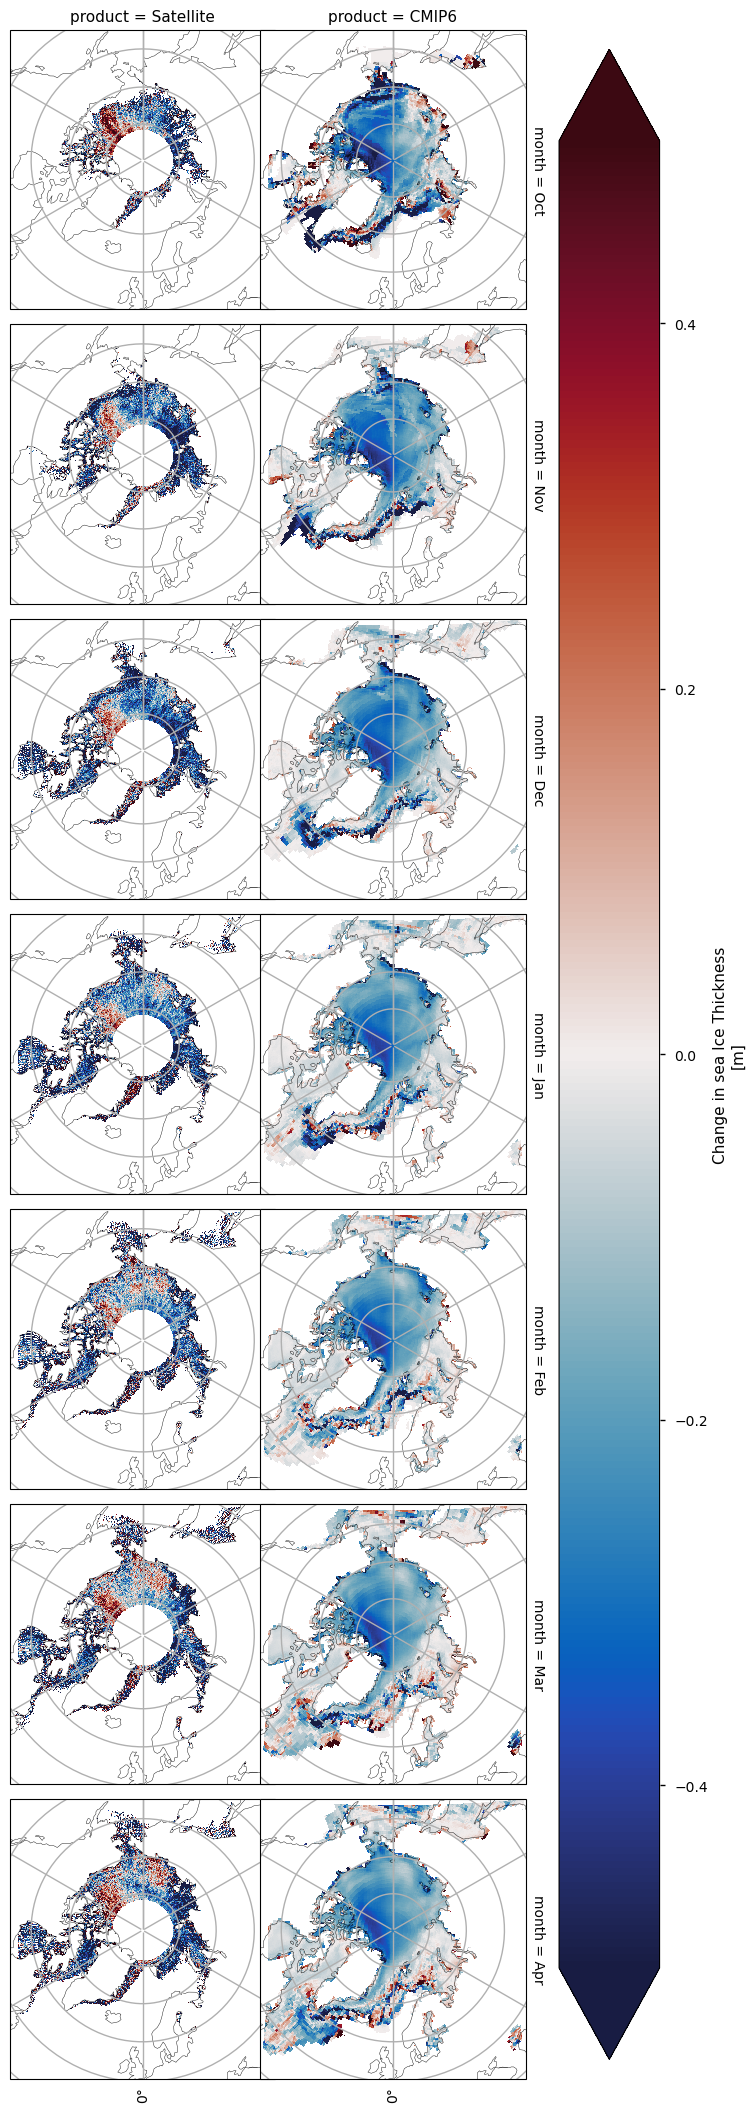

In [14]:
plot_change_maps(da_maps, projection_satellite)

### References
1. [CDS Satellite Sea Ice Thickness Product Quality Assessment Report](https://datastore.copernicus-climate.eu/documents/satellite-sea-ice-thickness/v3.0/WP2-FDDP-2022-09_C3S2-Lot3_PQAR-of-v3.0-SeaIceThickness-products_v3.2_Final.pdf)